# Project 7 - Create a model to predict the revenues of potential customers using ANOVA and Linear Regression.

🎯 Goal: Create a model to predict the future revenue of children based on their location, the revenue of their parents and the gini index; in order to target future customers.

## Part 3 - Preprocessing

### Get started

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.cbook import boxplot_stats  
import seaborn as sns
import missingno as msno 
from collections import Counter
import scipy.stats as st

%matplotlib inline
plt.style.use('seaborn-whitegrid')

In [3]:
# Read the data
quant = pd.read_csv(Path.cwd()/'Processed'/'quantile.csv',index_col=0) # Dataset with quantiles of child and parents
inc = pd.read_csv(Path.cwd()/'Processed'/'worldbank.csv',index_col=0) # World Bank data with income by quantile and country names
inc_avg = pd.read_csv(Path.cwd()/'Processed'/'worldbank_avg.csv')

/Users/aureliegiraud/.virtualenvs/env3.8/lib/python3.8/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


### Extract conditional probabilities

In [4]:
quant.head()

,name,y_child,y_parent,c_i_child,c_i_parent
0,Albania,4.854682,1.643313,93,70
1,Albania,1.908174,0.870868,72,45
2,Albania,0.294771,1.911118,14,75
3,Albania,2.123639,4.586099,76,94
4,Albania,1.655759,0.791240,68,41


In [18]:
# Get a dataframe with the conditional probability by combination of classes
proba_cond = quant.groupby(['name','c_i_child','c_i_parent']).count().iloc[:,0].reset_index()
proba_cond['proba_cond'] = proba_cond['y_child']/1000
proba_cond.drop(['y_child'], axis=1,inplace=True)
proba_cond.head()

,name,c_i_child,c_i_parent,proba_cond
0,Albania,1,1,0.120
1,Albania,1,2,0.060
2,Albania,1,3,0.047
3,Albania,1,4,0.039
4,Albania,1,5,0.030


In [6]:
proba_cond.name.nunique()

51

<b> Only 51 countries are covered by conditionnal probabilities: </b> It's due to some missing pj in Part 2.

In [15]:
# Check the results
tmp = proba_cond.groupby('name').sum().reset_index()

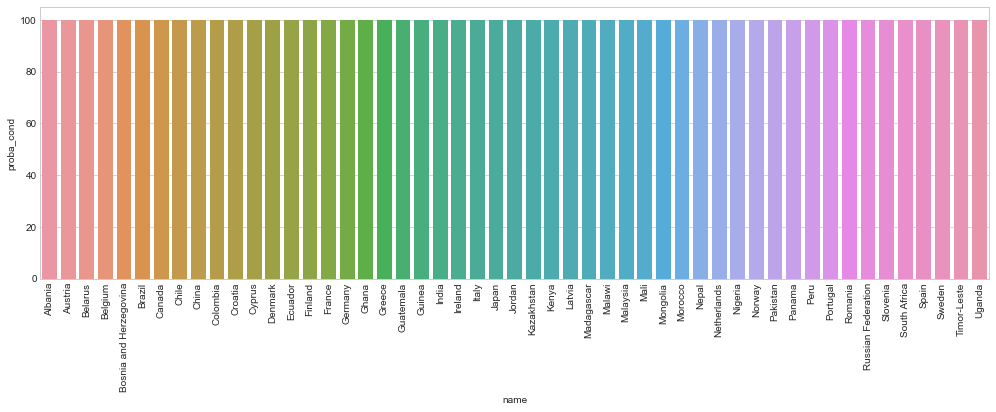

In [14]:
fig,ax = plt.subplots(figsize = (17,5))
plt.xticks(rotation=90)
sns.barplot(x="name", y="proba_cond", data=tmp,ax= ax)
plt.show()

<b> We must have 100% on the sum of conditional probabilities per country if the calculation is correct, which is the case here. </b>

### Calculate corresponding number of individuals

In [19]:
# Count total individuals to attribute by combination of classes
proba_cond['attribution'] = proba_cond['proba_cond']*500
proba_cond['attribution'] = proba_cond['attribution']
proba_cond.drop(['proba_cond'],axis=1,inplace=True)
proba_cond.head()

,name,c_i_child,c_i_parent,attribution
0,Albania,1,1,60.0
1,Albania,1,2,30.0
2,Albania,1,3,23.5
3,Albania,1,4,19.5
4,Albania,1,5,15.0


<b> It means (for example) that we need to attribute the class 1 to 60 rows where child class = 1 and country = Albania, into the World Bank Income dataframe </b>

In [20]:
# Check output
tmp = proba_cond.groupby(['name','c_i_child']).sum()[['attribution']].reset_index()
tmp.head(15)

,name,c_i_child,attribution
0,Albania,1,500.0
1,Albania,2,500.0
2,Albania,3,500.0
3,Albania,4,500.0
4,Albania,5,500.0
5,Albania,6,500.0
6,Albania,7,500.0
7,Albania,8,500.0
8,Albania,9,500.0
9,Albania,10,500.0


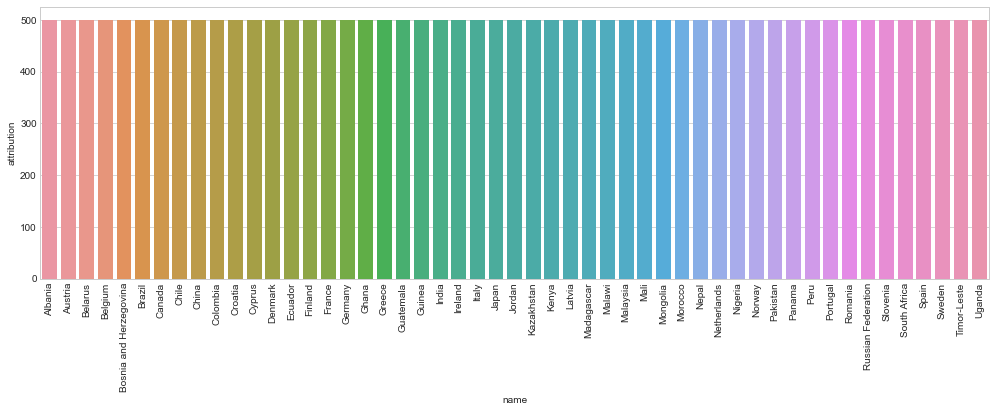

In [21]:
fig,ax = plt.subplots(figsize = (17,5))
plt.xticks(rotation=90)
sns.barplot(x="name", y="attribution", data=tmp,ax= ax)
plt.show()

<b> We should have a sum of individuals equals to 500 if the attribution is correct, which is the case here.</b> 

### Create Dataset with distribution corresponding to conditional probabilities

In [22]:
# Create a function that duplicates each combination of classes by the corresponding number of parents
def duplicates(data):
    attribut = pd.concat([data]*data['attribution'].values[0], ignore_index=True)
    attribut = attribut[['attribution']]
    return attribut

In [24]:
# Remove the rows with values < 1 and round the values
proba_cond['attribution'] = proba_cond['attribution'].astype(int)
tmp = proba_cond[proba_cond['attribution'] >= 1]

<b> We can't have a decimal values when it's about human being. We must have at least 1 individual and all attribution should be rounded. </b>

In [25]:
# Create a table with the number of individuals by combinations based on the conditional probabilities 
ref = tmp.groupby(['name','c_i_child','c_i_parent']).apply(duplicates).reset_index()
ref.head()

,name,c_i_child,c_i_parent,level_3,attribution
0,Albania,1,1,0,60
1,Albania,1,1,1,60
2,Albania,1,1,2,60
3,Albania,1,1,3,60
4,Albania,1,1,4,60


In [28]:
ref.drop(['level_3','attribution'],axis=1,inplace = True)
ref.head()

,name,c_i_child,c_i_parent
0,Albania,1,1
1,Albania,1,1
2,Albania,1,1
3,Albania,1,1
4,Albania,1,1


In [30]:
len(ref)

2424946

#### Creation of Final Dataset for Analysis

In [29]:
inc['quantile'] = inc['quantile'].astype(int)
inc.drop(['year_survey','nb_quantiles'], axis=1, inplace=True)
inc.head()

,quantile,income,gdpppp,name
2,1,728.89795,7297.0,Albania
3,2,916.66235,7297.0,Albania
4,3,1010.91600,7297.0,Albania
5,4,1086.90780,7297.0,Albania
6,5,1132.69970,7297.0,Albania


In [34]:
# Merge with the World Bank Income dataset
    #final = pd.merge(ref.reset_index(), inc_avg[['name','new_gini','income']], on = 'name', how = 'inner')
    #final.rename(columns= {'income':'avg_income'},inplace=True)
final = pd.merge(ref,inc[['name','quantile','income']], left_on=['name','c_i_child'],right_on=['name','quantile'], how = 'left')
final.head()

,name,c_i_child,c_i_parent,quantile,income
0,Albania,1,1,1,728.89795
1,Albania,1,1,1,728.89795
2,Albania,1,1,1,728.89795
3,Albania,1,1,1,728.89795
4,Albania,1,1,1,728.89795


In [35]:
# Quick look on the data
final[(final.name == 'Albania')& (final.c_i_parent == 1)]

,name,c_i_child,c_i_parent,quantile,income
0,Albania,1,1,1,728.89795
1,Albania,1,1,1,728.89795
2,Albania,1,1,1,728.89795
3,Albania,1,1,1,728.89795
4,Albania,1,1,1,728.89795
...,...,...,...,...,...
33730,Albania,72,1,72,3341.48700
34685,Albania,74,1,74,3439.62570
37060,Albania,79,1,79,3747.26760
37535,Albania,80,1,80,3820.13530


In [36]:
len(final)

2424946

In [37]:
final.drop(['c_i_child','quantile'],axis=1,inplace=True)

In [38]:
final.to_csv(Path.cwd()/'final_dataset.csv')